In [1]:
# N_simulation
from __future__ import division
import numpy as np
from scipy.integrate import odeint
from scipy import interpolate 
import matplotlib.pyplot as plt
import pandas as pd
import datetime
from datetime import date
import datetime
from local_functions import *
%matplotlib inline

In [2]:
x1 = pd.ExcelFile('../data/Parameters.xlsx')
x2 = pd.ExcelFile('../data/Data.xlsx')

# Import parameters into df1
df1 = x1.parse('Parameters')

# assigmment of parameters to values: 
for key,val in zip(df1.Parameter,df1.Indoor_value): # keep only relvenat parameters
    exec(key + '=val')
    # print(key,val)

n_reactors = 1

z = 0.085

In [3]:
# Import of IMS I and T data
dfI = pd.read_csv('../data/ims_data_2020_June_I.csv',encoding= 'unicode_escape',header=None)
dfT = pd.read_csv('../data/ims_data_2020_June_T.csv',encoding= 'unicode_escape',header=None)

In [4]:
# adjust I and T data for the different experiments (datasets sizes and resolution)

# experiment 1
# get T and I data
IV1, TV1,IV1_average,TV1_average = [],[],[],[]
for vali,valT in zip(dfI.iloc[1:1010:1][4],dfT.iloc[1:1010:1][3]):
    IV1.append(float(vali))
    TV1.append(float(valT))
# calculate average T and I data per hour
for i in range(1,len(IV1),6):
    IV1_average.append(0.1*0.43*np.mean(IV1[i-1:i+6:1])) # 0.1 shading factor and 0.43 PAR factor
    TV1_average.append(np.mean(TV1[i-1:i+6:1]))
print(len(TV1_average))
print(len(IV1_average))
    
# experiment 2
# get T and I data
IV2, TV2,IV2_average,TV2_average = [],[],[],[]
for vali,valT in zip(dfI.iloc[1010:1904:1][4],dfT.iloc[1010:1904:1][3]):
    IV2.append(float(vali))
    TV2.append(float(valT))
print(len(IV2))
print(len(TV2))
# calculate average T and I data per hour
for i in range(1,len(IV2),6):
    IV2_average.append(0.1*0.43*np.mean(IV2[i-1:i+6:1])) # 0.1 shading factor and 0.43 PAR factor
    TV2_average.append(np.mean(TV2[i-1:i+6:1]))
print(len(TV2_average))
print(len(IV2_average))

168
168
894
894
149
149


In [5]:
# Lists of initial and boundary conditions and empiric results for repetitions 1-2:

hour2i = int(7*24)+5 # length of experiment in hours
t0_all = [0, hour2i]
tf_all = [int(7*24), hour2i + int(6*24-5)]
mi_all = [[1,1,2,2,1,1,2,2,1,1,2,2],\
    [2,2,2,2,2,2,3,3,2,2,3,3]] # initial weights
mf_real = [[1.3,2.1,4,3,3.8,4.5,7.8,8.1,3.7,3.5,6.9,5.3],\
    [3,2.6,5,4.6,4.4,5.7,5.7,5.8,5.1,4.7,6.55,6.9]] # final densities
S_all = [[6, 6, 6, 6, 24, 24, 24, 24, 29, 29, 29, 29],[6, 6, 40, 40, 22.5, 22.5, 22.5, 22.5, 17.5, 17.5,17.5,17.5]] # salinities
d_all = [[0,0,0,0,1,1,1,1,2,2,2,2],[0,0,0,0,1,1,1,1,0.5,0.5,0.5,0.5]] # dilution rates
Nint0_all = [[3.01,3.01,3.01,3.01,3.01,3.01,3.01,3.01,3.01,3.01,3.01,3.01],\
    [4.09,4.09,4.09,4.09,4.09,4.09,4.09,4.09,4.09,4.09,4.09,4.09]] # initial internal N levels
Nintf_exps = [[2,3,4,5,7-1,8-1,9-1,10-1,12-2,13-2,14-2,15-2],\
    [2,3,4,5,0,8-1,9-1,10-1,12-2,13-2,14-2,15-2]] # new numbering used to ignore samples without Nintf measurement
Nintf_real = [[3.12,2.31,2.47,2.82,2.35,2.08,1.56,1.59,2.02,1.86,1.43,1.92],\
    [2.94,3.24,2.76,2.56,0,2.17,2.85,2.33,2.92,2.21,2.76,2.38]] # final internal N levels

TV_average = [TV1_average, TV2_average]
IV_average = [IV1_average, IV2_average]
xlabels_all = [['8 June', '11 June','15 June'],['15 June','18 June', '21 June']] #dates
l_all = [[['Brine\n6 PSU','  1:1\n24 PSU','  1:2\n29 PSU'],['Brine\n6 PSU','  1:1\n24 PSU','  1:2\n29 PSU']],[['Brine\n6 PSU','Brine+Salt\n  40 PSU','  1:1\n22.5 PSU','  1:0.5\n17.5 PSU'],['  1:1\n22.5 PSU','  1:0.5\n17.5 PSU']]] # legend labels

In [6]:
X  = np.loadtxt('indoor_calibration.txt')

In [7]:
# get 9 parameters from indoor_calibration (define X as X from the indoor calibration)
miu = 0.03

lossess20 = X[0]
Nintmax = X[1]
Nintcrit = X[2]
dNextoutdt = X[3]
Ks = X[4]
Vmax = X[5]
KI = X[6]
K0 = X[7]
Ka = X[8]

In [8]:
# optimized parameters: bounds
problem = {
    'num_vars': 6,
    'names': ['Smin','Sopt','Smax','Topt','Tmax','n'],
    'bounds': [[0,10],
               [15,35],
               [40,50],
               [15, 25],
               [31,37],
               [1,6]]
}

print(problem)

from scipy.optimize import Bounds
tmp = np.array(problem['bounds']).T.squeeze().tolist()
bounds = Bounds(tmp[0],tmp[1])

{'num_vars': 6, 'names': ['Smin', 'Sopt', 'Smax', 'Topt', 'Tmax', 'n'], 'bounds': [[0, 10], [15, 35], [40, 50], [15, 25], [31, 37], [1, 6]]}


In [9]:
# Growth function with ex-situ (IMS) data and Reading parameters
def Bottles_IMS(y, t, Nintcrit,Nintmax,Nintmin,Vmax,Ks,KN,miu,S,Z,KI,K0,Ka,Topt,\
            Tmin,Tmax,losses20,teta,Sopt,Smin,Smax, f1,f0,dilution,n,umol_to_percent_DW,dNextoutdt):
    """
    This is a second version of Reading_val. 
    The difference is that this function works with IMS data and not HOBO data
    """
    
    # every 4 state variables are a single reactor
    # n_reactors = 1
    
    # print(f't = {t}')
    Temp = f1(t)
    #Temp = 20 #https://isramar.ocean.org.il/isramar_data/TimeSeries.aspx
    I0 = f0(t)
    
    for i_reactor in range(n_reactors): # loop that constructs the coupled ODEs
        
        # state variables: 
        
        i = 3*i_reactor # temporary counter of the state variables
        
        Next = y[i]  
        Nint = y[i+1]  
        m = y[i+2]
        
        # Nutrient consumption:
        Neff = (Nintmax - Nint)/(Nintmax - Nintmin)  # units: [ ]
        if Next <= 0:
            uN = 0
        else: 
            uN = Vmax * Next / (Ks + Next)  # units: [umol N/g DW/h]
        if Nint >= Nintcrit:
            fN = 1
        else:
            fN = ((Nint - Nintmin)/Nint) / ((Nintcrit - Nintmin)/Nintcrit)  # units: [ ]
        fP = 1  #(N:P < 12)

        # density - light penetration effects:
        SD = m * 0.001 * 0.085 # Stocking Density. units: [g DW/ m^2] #### Check bottle dimensions
        I_average = (I0 / (K0 * Z + Ka * SD)) * (1 - np.exp(-(K0 * Z + Ka * SD))) # units: [umul photons/(m^2 s)]
        fI = I_average / (I_average + KI) # units: [-]

        
        # Temperature effects: 
       
        if Temp <= Topt:
            Tx = Tmin
        else:
            Tx = Tmax
        
        n = 2
        fT = np.exp(-2.3 * ((Temp - Topt) / (Tx - Topt))**n) # Temp from temperature data

        # S (salinity) effects
        if S < Sopt:
            Sx = Smin
            b = 2.5
            if S < 5:
                fS = ((S - Smin)/(Sopt - Sx))
            elif S >= 5:
                fS = 1 - ((S - Sopt)/(Sx - Sopt)) ** b           
        elif S >= Sopt:
            Sx = Smax
            b = 4.4 # found by solver in fs file
            fS = 1 - ((S - Sopt)/(Sx - Sopt)) ** b

        # empirically defined losses
        losses = losses20 * teta ** (Temp - 20)


        # limiting factors:
        g = min(fN,fI,fP) * fT * fS
        
        # Reactor Next -> Nint -> m and feedback
        dNext = - Neff * uN * m - dNextoutdt * Next # [umol N/l/h]
        dNint = umol_to_percent_DW * Neff * uN - Nint * miu * g #units: [%g N/g DW/h]

        if fI == 0:
            losses = 0
        dm = (miu * g - losses) * m #units: [g DW/l/h]
                
    return [dNext,dNint,dm]

In [10]:
# optimization

# Y1 = np.zeros([param_values.shape[0]])
# Y2 = np.zeros([param_values.shape[0]])

# evaluate_model1 = []
# evaluate_model2 = []

#  two repetitions of the experiment
repetitions = 2

# w = 0

# for p, X in enumerate(param_values):

def residual(X, plot_on = False):
    """ estimate RMS, plotting is disabled by default """

    Smin = X[0]
    Sopt = X[1]
    Smax = X[2]
    Topt = X[3]
    Tmax = X[4]
    n = X[5]


    # growth and N dynamics figures (based on IMS data) 
    DATA = []
    Errors, RMSRE_m = [], []
    Errors, RMSRE_Nint = [], []
    RMSRE_m_all, RMSRE_Nint_all = [],[]

    # model simulation
    for k in range(repetitions):
        # print(f'k = {k}')
        # Square_Errors_m = []
        # Square_Errors_Nint = []

        if plot_on:
            fig, ax = plt.subplots(3,2,figsize=(13,8))
            fig2, ax2 = plt.subplots(2,1,figsize=(13,6))
            xlabels = xlabels_all[k]

        t = np.arange(t0_all[k], tf_all[k])
        
        # T Data 
        TV_reduced = TV_average[k][:len(t)]

        f1 = interpolate.interp1d(t, TV_reduced,kind = 'linear')

        # I Data
        IV_reduced = IV_average[k][:len(t)]
        f0 = interpolate.interp1d(t, IV_reduced,kind = 'linear')

        xlabels = xlabels_all[k]

        for j in range(len(mi_all[k])):
            #print('j = ' + str(j))

            # calculate and plot model results for each initial condition 
            # (runs only on odd numbers, to avoid double work)
            if j % 2 == 0:
                NEXT, NINT, M, T = [],[],[],[]

                line = '--'
                S = S_all[k][j]
                m0 = 0.15 * mi_all[k][j]
                Nint0 = Nint0_all[k][j]
                d = d_all[k][j]
                Next0 = Next00 / (1 + d)
                x0 = n_reactors*[Next0, Nint0, m0]

                if d == 0 and S < 10:
                    color = 'blue'
                elif d == max(d_all[k]):
                    color = 'turquoise'
                elif d != 0 and d != max(d_all[k]):
                    color = 'dodgerblue'
                elif d == 0 and S > 10:
                    color = 'red'
                    line = '-.'

                # setup initial conditions identical for all reactors
                args = (Nintcrit,Nintmax,Nintmin,Vmax,Ks,KN,miu,S,Z,KI,K0,Ka,Topt,Tmin,Tmax,losses20,
                        teta,Sopt,Smin,Smax,f1,f0,dilution,n,umol_to_percent_DW,dNextoutdt)



                # solve the ODEs using the new syntax
                y = odeint(Bottles_IMS, x0, t[:-1], args=args, printmessg=0, hmax=.1)

                # take the solution of the state variables:
                NEXT.append(y[:, 0]/1000*62)
                NINT.append(y[:, 1])
                M.append(y[:, 2])

                T.append(t[:-1])

                t = T[0]

                if mi_all[k][j] < max(mi_all[k]):
                    r = 0
                else:
                    r = 1
                l = l_all[k][r]

                
                
            

 


            data = {'T':T[0],'Next':NEXT[0],'Nint':NINT[0],'m':M[0]}
            DATA.append(data)

            if plot_on:
                ax[0,r].plot(T[-1], NEXT[-1],linestyle = line,markersize=3.5,color=color)
                ax[0,r].set_ylim([0, Next00*1.2/1000*62])
                ax[1,r].plot(T[-1], NINT[-1],linestyle = line,markersize=3.5,color=color)
                ax[1,r].set_ylim([0.5,5.5])
                ax[2,r].plot(T[-1], M[-1]/0.15,linestyle = line,markersize=3.5,color=color)
                
                col = len(l)
                ax[0,r].legend(l,ncol=col,loc='upper right',fontsize='medium',markerscale=2,columnspacing = 0.2,handletextpad = 0.3)#,edgecolor='white')
                                
                ax[2,r].plot(t[-1],mf_real[k][j],'*',markersize = 6,color=color)

                print('exp: ' + str(j+2))
                print('Real Nint is: ' + str(Nintf_exps[k][j]))
                if Nintf_exps[k][j] == j + 2:
                    print('exp: ' + str(j + 2))
                    ax[1,r].plot(t[-1],Nintf_real[k][j],'*',markersize = 6,color=color)
                        
                ax[0,r].set_xticklabels([])
                ax[1,r].set_xticklabels([])
                ax[2,r].set_xticks(t[0:len(t):int(len(t)/2-1)])
                ax[2,r].set_xticklabels([str(i) for i in xlabels], rotation=45,fontsize=10, weight="bold")

                ax[0,r].set_ylabel('Next \n [ppm $NO3^{-}$]', fontsize=12, weight="bold")
                ax[1,r].set_ylabel('Nint \n [% g N $g DW^{-1}$]',fontsize=12, weight="bold")
                ax[2,r].set_ylabel('m \n [g FW $l^{-1}$]',fontsize=12, weight="bold")
                
                plt.tight_layout()

                # plot I and T
                ax2[0].plot(T[-1],TV_reduced[:len(T[-1])],'.',markersize=3,color='black')
                ax2[1].plot(T[-1],IV_reduced[:len(T[-1])],'.',markersize=3,color='k')
                    
                ax2[0].set_ylabel('Temperature \n[C]',fontsize=11, weight="bold")
                ax2[1].set_ylabel('Light Intensity \n[µmol photons $m^{-2}$ $second^{-1}$]',fontsize=11, weight="bold")

                ax2[0].set_xticklabels([])
                ax2[1].set_xticklabels([])
                ax2[1].set_xticks(t[0:len(t):int(len(t)/2-1)])
                ax2[1].set_xticklabels([str(i) for i in xlabels], rotation=45,fontsize=10, weight="bold")
                
                    
            # if plot_on:
            #     plt.figure()
            #     plt.plot(t[:-1],y)
            #     plt.show()

            # m error

            final_m = round(M[-1][-1],2)
            measured_m = round(mf_real[k][j],2)
            RMSRE_m_all.append(round((measured_m - final_m/0.15) / measured_m,3)**2) # Square_Errors_m and RMSRE_m_all are the same in the mean while

            # Nint error

            final_Nint = round(NINT [-1][-1],2)

            if Nintf_exps[k][j] == j + 2: # ignoring samples without Nintf measurement
                measured_Nint = round(Nintf_real[k][j],2)
                error_Nint = round((measured_Nint - final_Nint) / measured_Nint,3)
                # square_error_Nint = error_Nint**2
                # Square_Errors_Nint.append(square_error_Nint)
                RMSRE_Nint_all.append((error_Nint**2))

            # plt.tight_layout()
        ...
        ...

    RMSREm = (np.mean(RMSRE_m_all))**0.5
    RMSRENint = (np.mean(RMSRE_Nint_all))**0.5

    return np.sqrt(RMSREm**2 + RMSRENint**2)

    # evaluate_model1.append(RMSREm)
    # evaluate_model2.append(RMSRENint)

    # Y1[p] = round(evaluate_model1[-1],3)
    # Y2[p] = round(evaluate_model2[-1],3)

    # print(w)
    # w = w+1

In [11]:
from scipy.optimize import minimize

param_values = np.array(problem['bounds']).T.squeeze()
print(f"Initial guess is : {param_values[0,:]}")



Initial guess is : [ 0 15 40 15 31  1]


In [12]:

sol = minimize(residual,param_values[0,:],bounds=bounds,method='SLSQP')

In [13]:
print(sol)

     fun: 0.7313738660111243
     jac: array([0., 0., 0., 0., 0., 0.])
 message: 'Optimization terminated successfully'
    nfev: 7
     nit: 1
    njev: 1
  status: 0
 success: True
       x: array([ 0., 15., 40., 15., 31.,  1.])


In [14]:
X = sol.x

In [15]:
np.savetxt('brine_calibration.txt',X)

exp: 2
Real Nint is: 2
exp: 2
exp: 3
Real Nint is: 3
exp: 3
exp: 4
Real Nint is: 4
exp: 4
exp: 5
Real Nint is: 5
exp: 5
exp: 6
Real Nint is: 6
exp: 6
exp: 7
Real Nint is: 7
exp: 7
exp: 8
Real Nint is: 8
exp: 8
exp: 9
Real Nint is: 9
exp: 9
exp: 10
Real Nint is: 10
exp: 10
exp: 11
Real Nint is: 11
exp: 11
exp: 12
Real Nint is: 12
exp: 12
exp: 13
Real Nint is: 13
exp: 13
exp: 2
Real Nint is: 2
exp: 2
exp: 3
Real Nint is: 3
exp: 3
exp: 4
Real Nint is: 4
exp: 4
exp: 5
Real Nint is: 5
exp: 5
exp: 6
Real Nint is: 0
exp: 7
Real Nint is: 7
exp: 7
exp: 8
Real Nint is: 8
exp: 8
exp: 9
Real Nint is: 9
exp: 9
exp: 10
Real Nint is: 10
exp: 10
exp: 11
Real Nint is: 11
exp: 11
exp: 12
Real Nint is: 12
exp: 12
exp: 13
Real Nint is: 13
exp: 13


0.7313738660111243

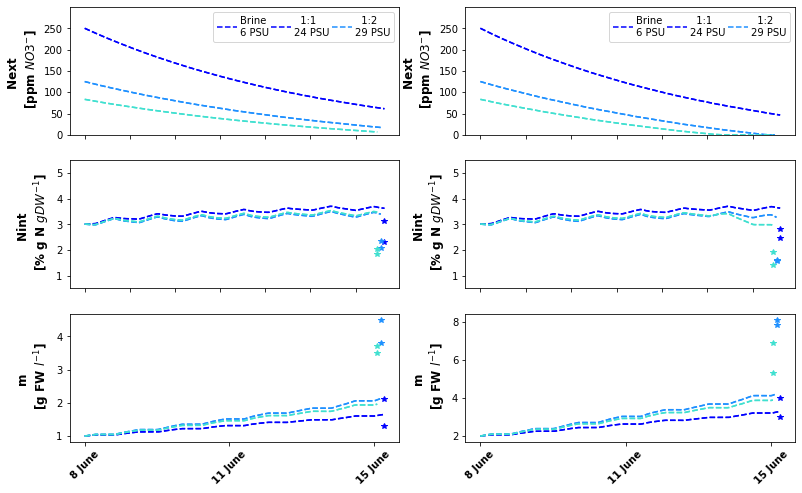

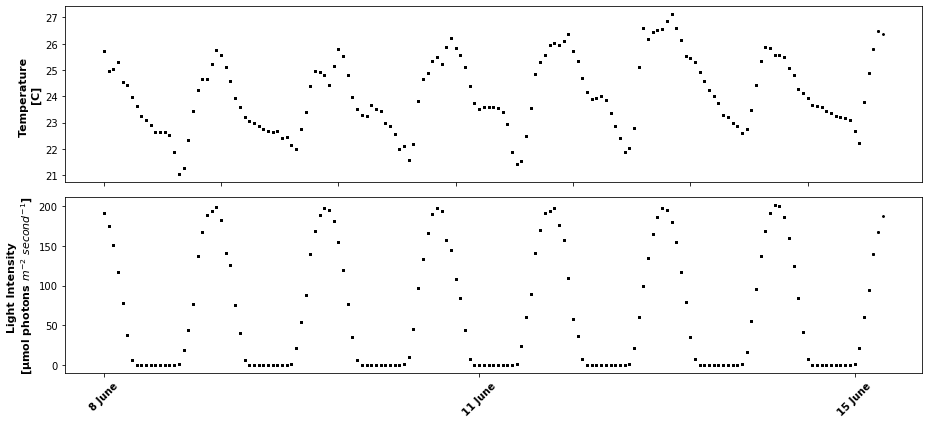

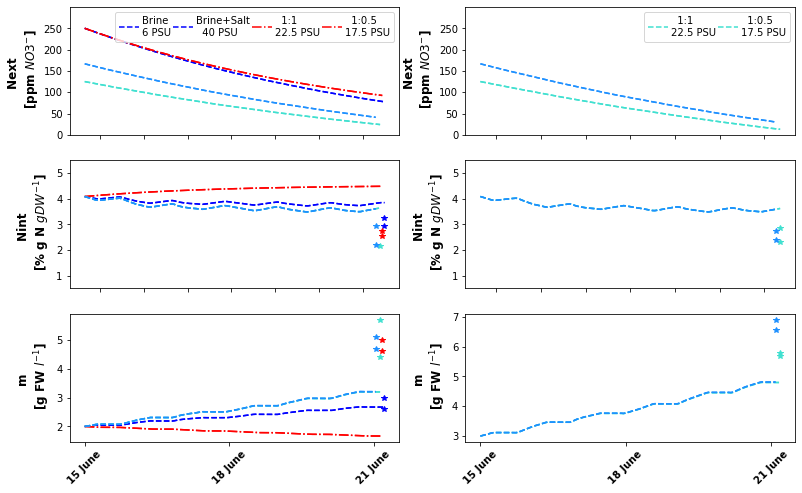

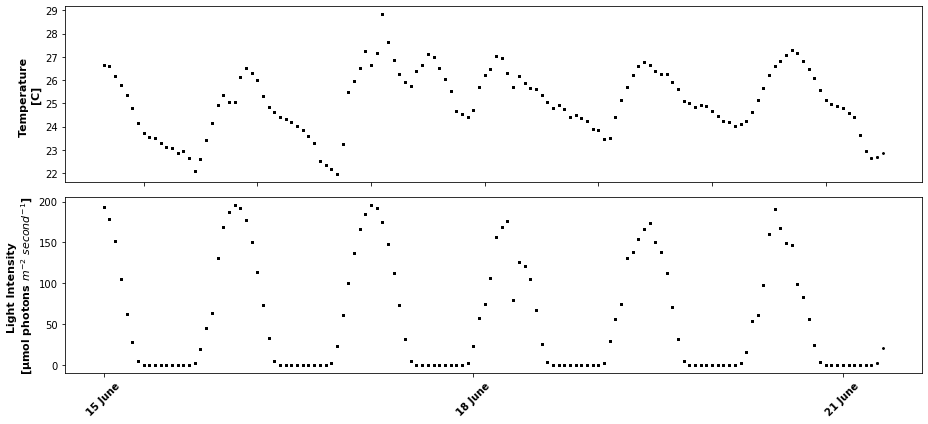

In [16]:
repetitions = 2
residual(X, plot_on=True)